In [1]:
#!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
test = pd.read_csv('./data/test.csv')

In [4]:
df = pd.read_pickle('./data/data_2.pkl')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8022925 entries, 826485 to 8849409
Data columns (total 41 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   month_id                     int8   
 1   shop_id                      int8   
 2   item_id                      int16  
 3   cnt_month                    float32
 4   city_id                      int8   
 5   cat_id                       int8   
 6   main_cat                     int8   
 7   sub_cat                      int8   
 8   year                         int16  
 9   month                        int8   
 10  sales_month                  int8   
 11  cnt_month_1                  float32
 12  cnt_month_2                  float32
 13  cnt_month_3                  float32
 14  cnt_month_6                  float32
 15  cnt_month_12                 float32
 16  item_id_mean_cnt_1           float32
 17  item_id_mean_cnt_2           float32
 18  item_id_mean_cnt_3           float32


In [6]:
df.head()

,month_id,shop_id,item_id,cnt_month,city_id,cat_id,main_cat,sub_cat,year,month,...,item_id/city_id_mean_cnt_1,item_id/city_id_mean_cnt_2,item_id/city_id_mean_cnt_3,item_id/city_id_mean_cnt_6,item_id/city_id_mean_cnt_12,shop_id/cat_id_mean_cnt_1,shop_id/cat_id_mean_cnt_2,shop_id/cat_id_mean_cnt_3,shop_id/cat_id_mean_cnt_6,shop_id/cat_id_mean_cnt_12
826485,3,25,8092,3.0,13,40,11,6,2013,4,...,1.000000,2.142857,0.0,0.0,0.0,1.088162,1.049317,0.0,0.0,0.0
826486,3,25,7850,3.0,13,30,8,54,2013,4,...,3.714286,2.285714,0.0,0.0,0.0,3.672316,2.282443,0.0,0.0,0.0
826487,3,25,8051,3.0,13,66,14,47,2013,4,...,0.000000,0.428571,0.0,0.0,0.0,1.827586,1.389474,0.0,0.0,0.0
826488,3,25,8088,1.0,13,55,13,4,2013,4,...,0.285714,0.000000,0.0,0.0,0.0,0.598756,0.562549,0.0,0.0,0.0
826489,3,25,8089,1.0,13,55,13,4,2013,4,...,0.571429,0.000000,0.0,0.0,0.0,0.598756,0.562549,0.0,0.0,0.0


In [7]:
s = ['cnt_month', 'cnt_month_1','cnt_month_2', 'cnt_month_3','cnt_month_6','cnt_month_12', 
     'item_id_mean_cnt_1','item_id_mean_cnt_2', 'item_id_mean_cnt_3', 'item_id_mean_cnt_6', 'item_id_mean_cnt_12',
     'sub_cat_mean_cnt_1','sub_cat_mean_cnt_2', 'sub_cat_mean_cnt_3', 'sub_cat_mean_cnt_6', 'sub_cat_mean_cnt_12',
     'price_mean_mean_cnt_1', 'price_mean_mean_cnt_2', 'price_mean_mean_cnt_3','price_mean_mean_cnt_6', 'price_mean_mean_cnt_12',
     'item_id/city_id_mean_cnt_1', 'item_id/city_id_mean_cnt_2', 'item_id/city_id_mean_cnt_3', 'item_id/city_id_mean_cnt_6', 'item_id/city_id_mean_cnt_12',
     'shop_id/cat_id_mean_cnt_1','shop_id/cat_id_mean_cnt_2', 'shop_id/cat_id_mean_cnt_3','shop_id/cat_id_mean_cnt_6','shop_id/cat_id_mean_cnt_12']

In [8]:
# value clip(0~20)
df[s] = df[s].clip(0, 20)

In [9]:
# train/validation/test data split
X_train = df[df['month_id'] < 33].drop(['cnt_month'], axis=1)
Y_train = df[df['month_id'] < 33]['cnt_month']

X_valid = df[df['month_id'] == 33].drop(['cnt_month'], axis=1)
Y_valid = df[df['month_id'] == 33]['cnt_month']

X_test = df[df['month_id'] == 34].drop(['cnt_month'], axis=1)

In [10]:
model = CatBoostRegressor(
    max_depth=10,              # 트리의 최대 깊이
    n_estimators = 1000,       # 최대 트리 수
    eta = 0.3,                 # 학습률 : 증감률을 줄이는데 사용
    random_seed=123            # 훈련에 사용되는 랜덤 시드
    )

In [11]:
ts = time.time()

model.fit(
    X_train, Y_train, 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],  # 유효성 검사 데이터 세트
    verbose=True,                                      # True : 상세로그수준 / False : 자동로그수준 / int : 상세로그수준을 사용, 매개변수로 로깅기간 사용 
    early_stopping_rounds = 20                         # 반복횟수 설정
    )

print('소요시간: ',time.time()-ts)

0:	learn: 1.0971982	test: 1.0971982	test1: 0.9782267	best: 0.9782267 (0)	total: 4.4s	remaining: 1h 13m 14s
1:	learn: 1.0198380	test: 1.0198380	test1: 0.9201328	best: 0.9201328 (1)	total: 8.65s	remaining: 1h 11m 54s
2:	learn: 0.9742655	test: 0.9742655	test1: 0.8868340	best: 0.8868340 (2)	total: 12.6s	remaining: 1h 9m 48s
3:	learn: 0.9479204	test: 0.9479204	test1: 0.8684058	best: 0.8684058 (3)	total: 16.7s	remaining: 1h 9m 28s
4:	learn: 0.9324142	test: 0.9324142	test1: 0.8588299	best: 0.8588299 (4)	total: 21.5s	remaining: 1h 11m 22s
5:	learn: 0.9198935	test: 0.9198935	test1: 0.8449815	best: 0.8449815 (5)	total: 25.7s	remaining: 1h 11m 2s
6:	learn: 0.9133043	test: 0.9133043	test1: 0.8424409	best: 0.8424409 (6)	total: 29.7s	remaining: 1h 10m 9s
7:	learn: 0.9085742	test: 0.9085742	test1: 0.8413823	best: 0.8413823 (7)	total: 33.7s	remaining: 1h 9m 41s
8:	learn: 0.9035260	test: 0.9035260	test1: 0.8358505	best: 0.8358505 (8)	total: 37.8s	remaining: 1h 9m 24s
9:	learn: 0.8999134	test: 0.8999134

76:	learn: 0.8261024	test: 0.8261024	test1: 0.8131038	best: 0.8125649 (62)	total: 5m 31s	remaining: 1h 6m 13s
77:	learn: 0.8257195	test: 0.8257195	test1: 0.8152567	best: 0.8125649 (62)	total: 5m 35s	remaining: 1h 6m 7s
78:	learn: 0.8250747	test: 0.8250747	test1: 0.8145945	best: 0.8125649 (62)	total: 5m 40s	remaining: 1h 6m 4s
79:	learn: 0.8242720	test: 0.8242720	test1: 0.8134240	best: 0.8125649 (62)	total: 5m 44s	remaining: 1h 6m 4s
80:	learn: 0.8235121	test: 0.8235121	test1: 0.8130989	best: 0.8125649 (62)	total: 5m 49s	remaining: 1h 6m 2s
81:	learn: 0.8230364	test: 0.8230364	test1: 0.8129288	best: 0.8125649 (62)	total: 5m 53s	remaining: 1h 5m 58s
82:	learn: 0.8225345	test: 0.8225345	test1: 0.8127246	best: 0.8125649 (62)	total: 5m 57s	remaining: 1h 5m 54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8125648801
bestIteration = 62

Shrink model to first 63 iterations.
소요시간:  364.9297089576721


In [12]:
Y_pred = model.predict(X_valid)

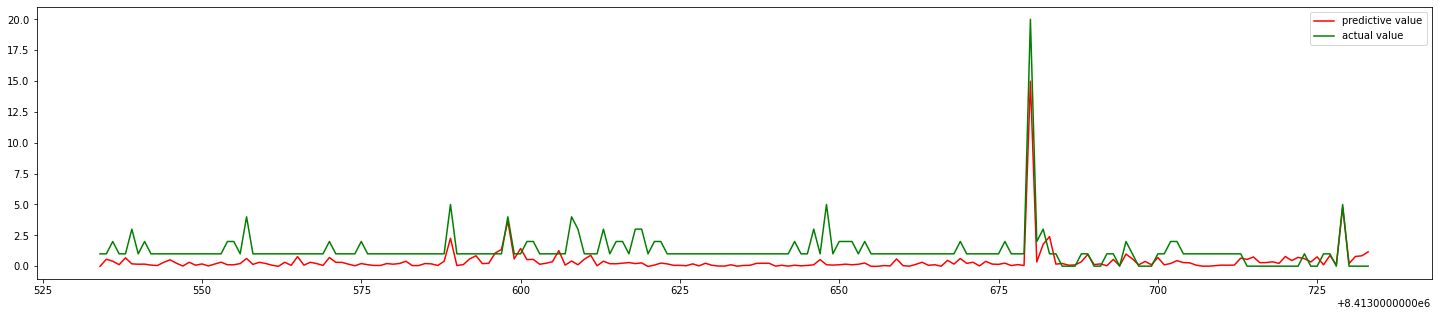

In [13]:
submission = pd.DataFrame({
    "ID": X_valid.index, 
    "item_cnt_month": Y_pred
})
x = submission['ID'].head(200)
y_pred = submission['item_cnt_month'].head(200)
y_true = Y_valid.head(200)
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)
ax.plot(x, y_pred, label = 'predictive value', color = 'red')
ax.plot(x, y_true, label = 'actual value', color = 'green')

ax.legend()

plt.show()

In [14]:
Y_test = model.predict(X_test)

In [15]:
# 제출 파일 생성
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('./submission/submission_CatBoost_2022022804.csv', index=False)